## Database filtering

Data filtering the visual database related to rat's behavior - removal of movement interrupting acuity tests:
1. Rearing
2. Scratching
3. Moving around

In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate

%matplotlib inline
sns.set(color_codes=True)

path = '../datasets/'

dfrat = pd.read_hdf(path+'relationalDatabase.h5', 'Rat_Behavior').set_index('index')

hyperparam = { 'BPFlimit' : 0.5 ,
               'LPFlimit' : 0.13,
               'MOVElimit': 0.02,}


## Rearing removal
Removal based on Y axis postion limit - low pass filter

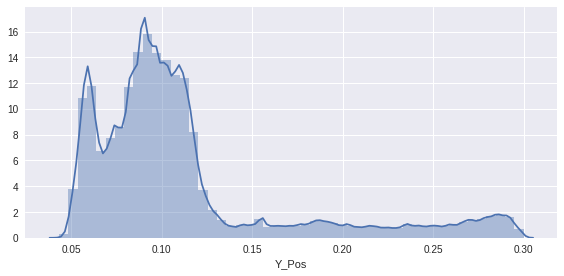

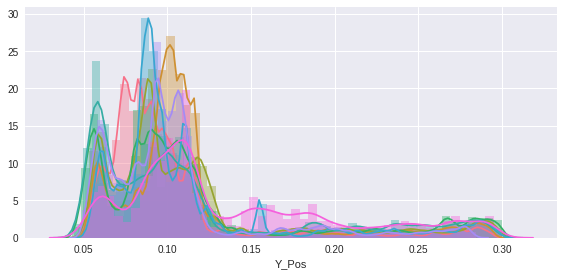

In [2]:
g = sns.FacetGrid(data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

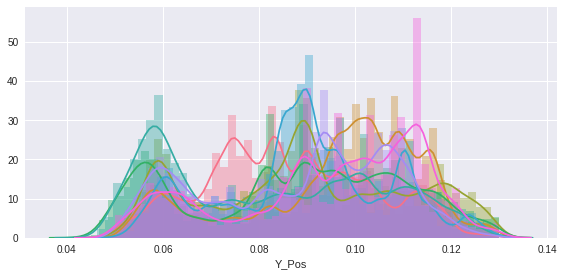

In [3]:
# Low pass filetring of Y position
rearinglimit = 0.13
dfratnew = dfrat[dfrat['Y_Pos'] < rearinglimit]

# Plotting after filtering
g = sns.FacetGrid(hue='session_id', data=dfratnew, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

In [4]:
'''

g = sns.FacetGrid(hue='session_id', data=dfratnew[dfratnew['session_id']==1], size=6, aspect=2.5)
#g.map(sns.regplot, 'Time', 'Y_Pos', scatter_kws={'s':2}, fit_reg=False);
g.map(plt.plot, "Time", "Y_Pos", alpha=1, linewidth=0.8);
g = sns.FacetGrid(hue='session_id', data=dfratnew[dfratnew['session_id']==1], size=6, aspect=2.5)
g.map(plt.plot, "Time", "Y_Ori", alpha=1, linewidth=0.8, color='r');

#g = sns.FacetGrid(hue='session_id', data=dfratnew[dfratnew['session_id']==1], size=6, aspect=2.5)
g = sns.FacetGrid(hue='session_id', data=dfratnew, size=6, aspect=2.5)
g.map(sns.regplot, 'Y_Pos', 'Y_Ori', scatter_kws={'s':2.5}, fit_reg=False);

'''

'\n\ng = sns.FacetGrid(hue=\'session_id\', data=dfratnew[dfratnew[\'session_id\']==1], size=6, aspect=2.5)\n#g.map(sns.regplot, \'Time\', \'Y_Pos\', scatter_kws={\'s\':2}, fit_reg=False);\ng.map(plt.plot, "Time", "Y_Pos", alpha=1, linewidth=0.8);\ng = sns.FacetGrid(hue=\'session_id\', data=dfratnew[dfratnew[\'session_id\']==1], size=6, aspect=2.5)\ng.map(plt.plot, "Time", "Y_Ori", alpha=1, linewidth=0.8, color=\'r\');\n\n#g = sns.FacetGrid(hue=\'session_id\', data=dfratnew[dfratnew[\'session_id\']==1], size=6, aspect=2.5)\ng = sns.FacetGrid(hue=\'session_id\', data=dfratnew, size=6, aspect=2.5)\ng.map(sns.regplot, \'Y_Pos\', \'Y_Ori\', scatter_kws={\'s\':2.5}, fit_reg=False);\n\n'

## Scratching and cleaning removal
Removal based on Y axis orientation limit - band pass filter

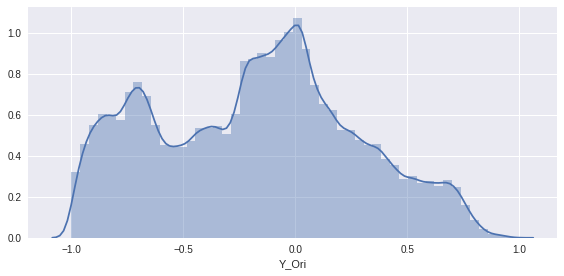

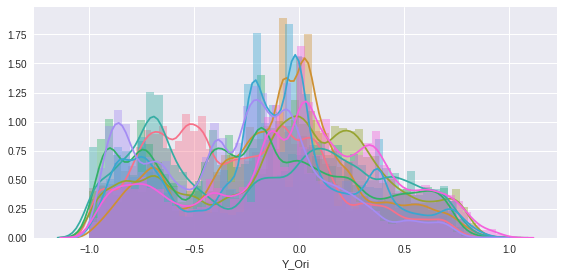

In [5]:
g = sns.FacetGrid(data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');

g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');

# add line on plots with filter val

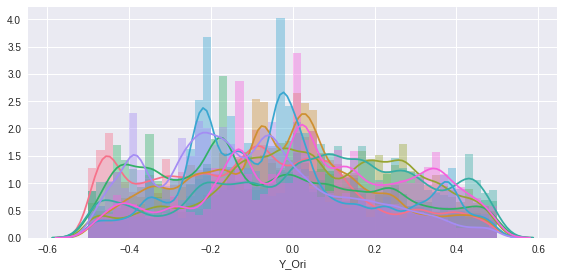

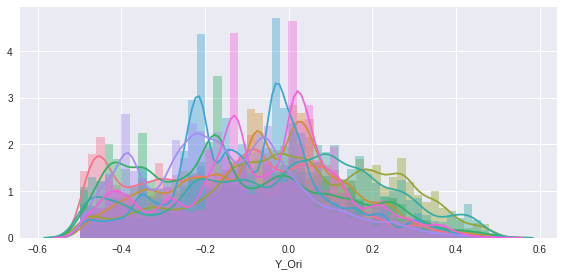

In [6]:
# Band pass filetring of Y orientation
orientylimit = 0.5
dfratnew2 = dfrat[np.absolute(dfrat['Y_Ori']) < orientylimit]
dfratnew3 = dfratnew[np.absolute(dfratnew['Y_Ori']) < orientylimit]

# Plotting after filtering
g = sns.FacetGrid(hue='session_id', data=dfratnew2, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');
g = sns.FacetGrid(hue='session_id', data=dfratnew3, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');

## Smoothing the data
Rolling window applyed on X, Y, Z positiona and orientation data.

In [7]:
dfrat0 = dfrat.copy().groupby(['session_id']).get_group(0)

pos_l = dfrat0.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Position', value_vars=['X_Pos', 'Y_Pos', 'Z_Pos'], var_name='Dimension')

ori_l = dfrat0.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')


In [8]:
dfrat0SM = dfrat0.copy()

dfrat0SM['X_Pos'] = dfrat0SM['X_Pos'].rolling(window=5000).mean()
dfrat0SM['Y_Pos'] = dfrat0SM['Y_Pos'].rolling(window=5000).mean()
dfrat0SM['Z_Pos'] = dfrat0SM['Z_Pos'].rolling(window=5000).mean()

dfrat0SM['X_Ori'] = dfrat0SM['X_Ori'].rolling(window=5000).mean()
dfrat0SM['Y_Ori'] = dfrat0SM['Y_Ori'].rolling(window=5000).mean()
dfrat0SM['Z_Ori'] = dfrat0SM['Z_Ori'].rolling(window=5000).mean()


In [9]:
pos_lSM = dfrat0SM.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Position', value_vars=['X_Pos', 'Y_Pos', 'Z_Pos'], var_name='Dimension')

ori_lSM = dfrat0SM.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')


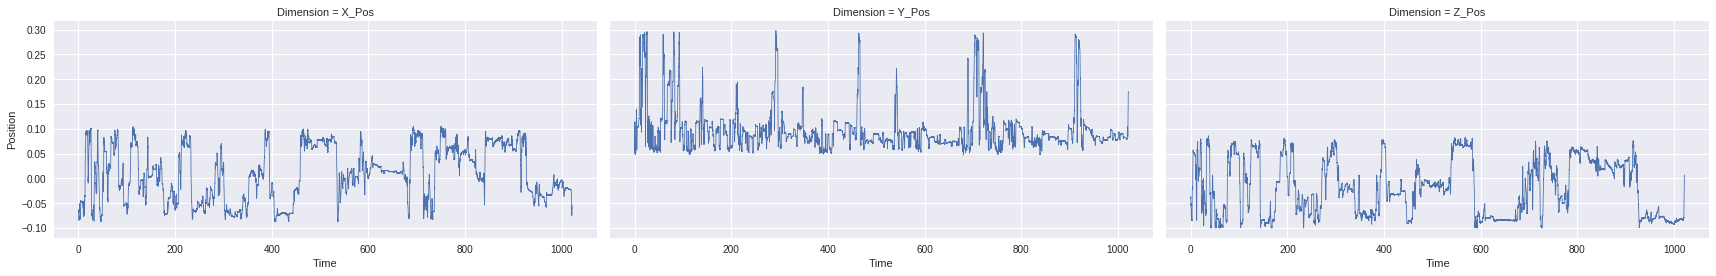

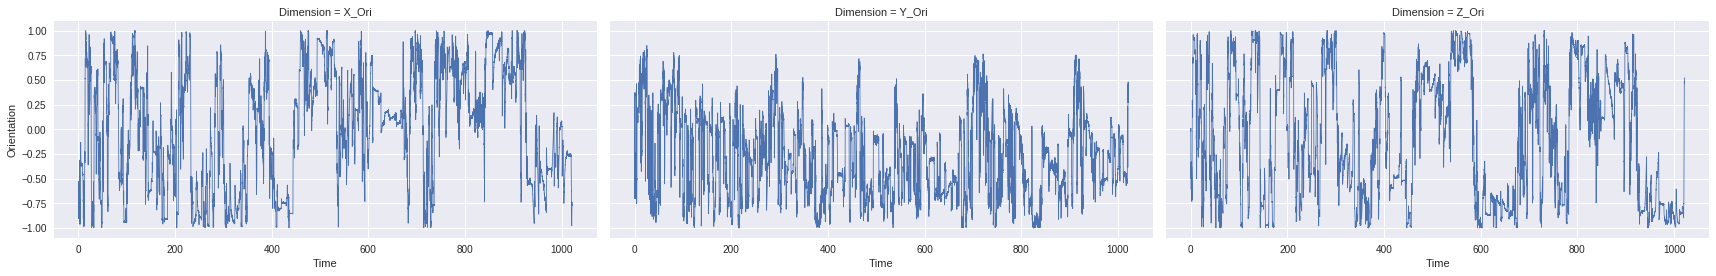

In [10]:
g = sns.FacetGrid(col='Dimension', data=pos_l, size=4, aspect=2)
g.map(plt.plot, "Time", "Position", alpha=1, linewidth=0.8);

g = sns.FacetGrid(col='Dimension', data=ori_l, size=4, aspect=2)
g.map(plt.plot, "Time", "Orientation", alpha=1, linewidth=0.8);


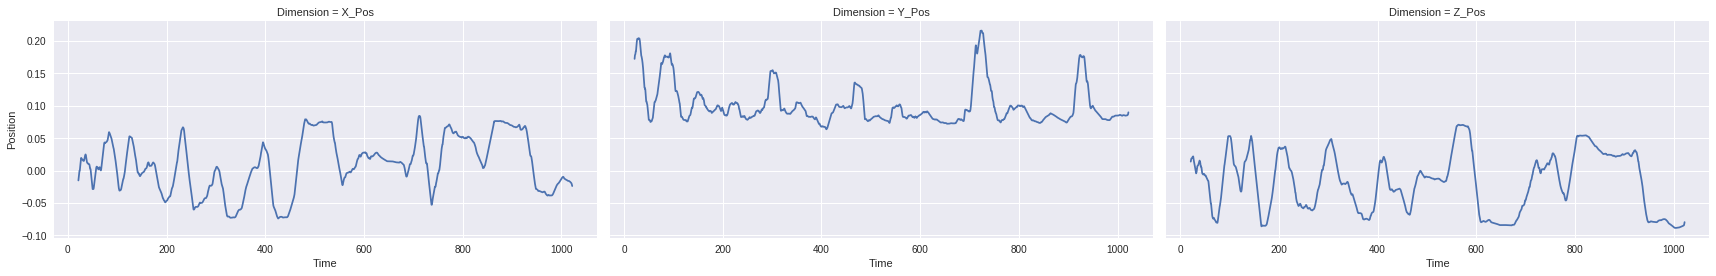

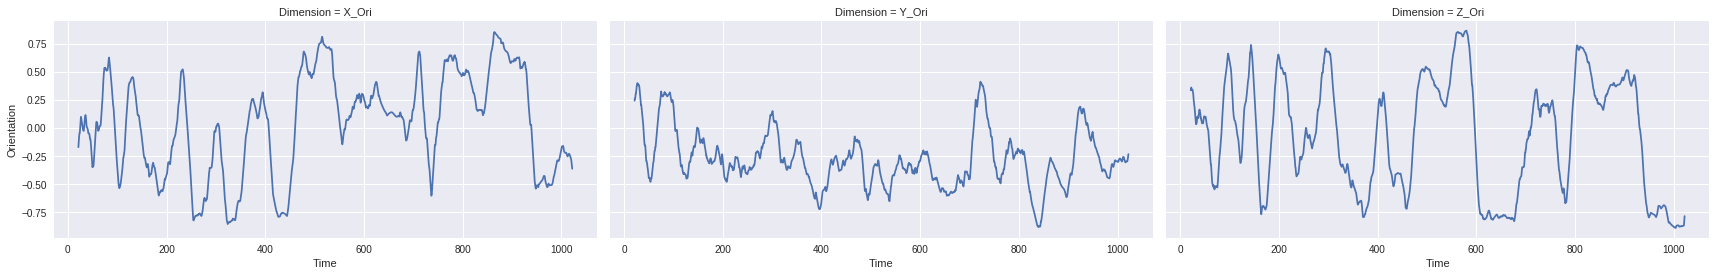

In [11]:
g = sns.FacetGrid(col='Dimension', data=pos_lSM, size=4, aspect=2)
g.map(plt.plot, "Time", "Position", alpha=1);

g = sns.FacetGrid(col='Dimension', data=ori_lSM, size=4, aspect=2)
g.map(plt.plot, "Time", "Orientation", alpha=1);

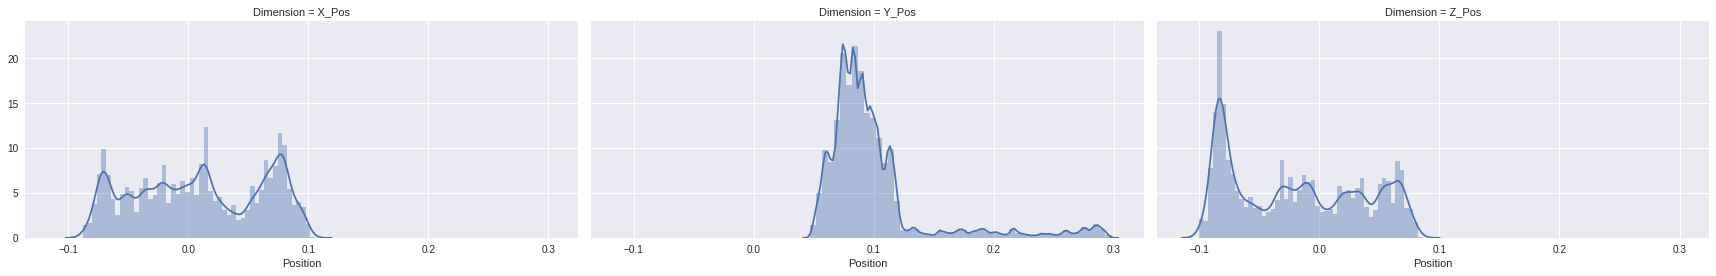

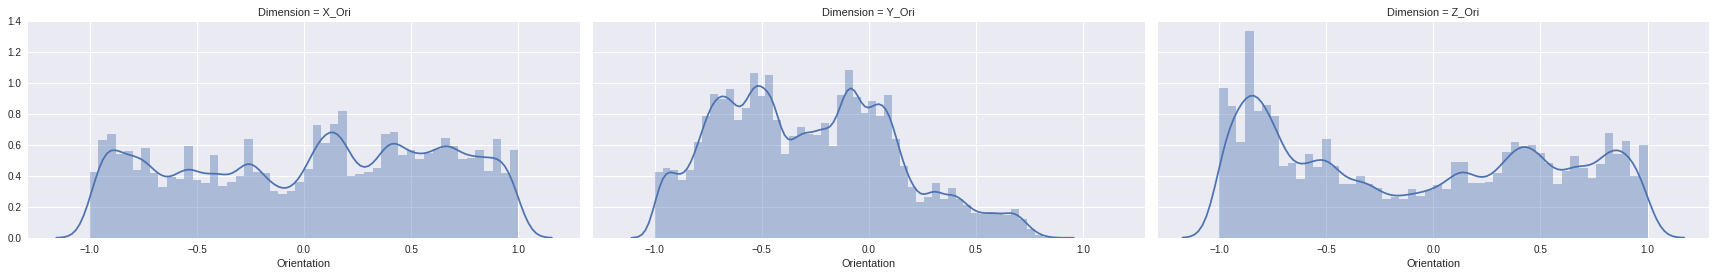

In [12]:
g = sns.FacetGrid(col='Dimension', data=pos_l, size=4, aspect=2)
g.map(sns.distplot, 'Position');

g = sns.FacetGrid(col='Dimension', data=ori_l, size=4, aspect=2)
g.map(sns.distplot, 'Orientation');


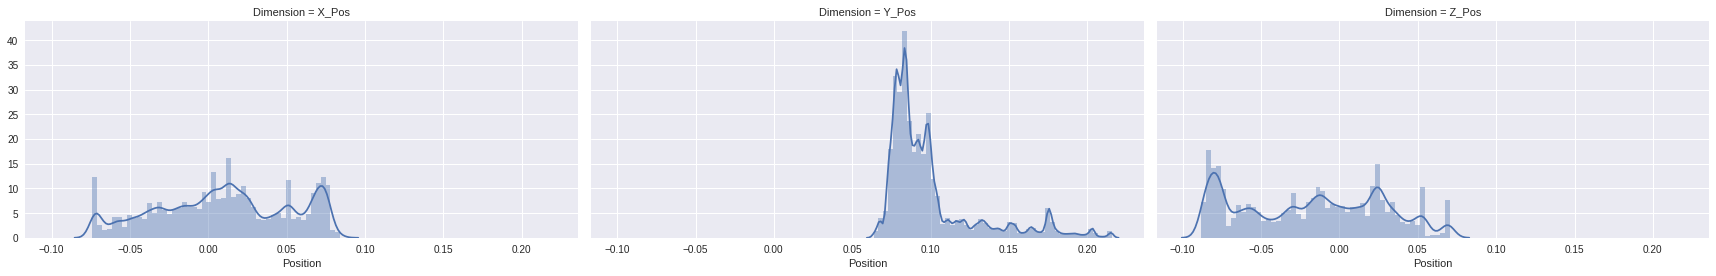

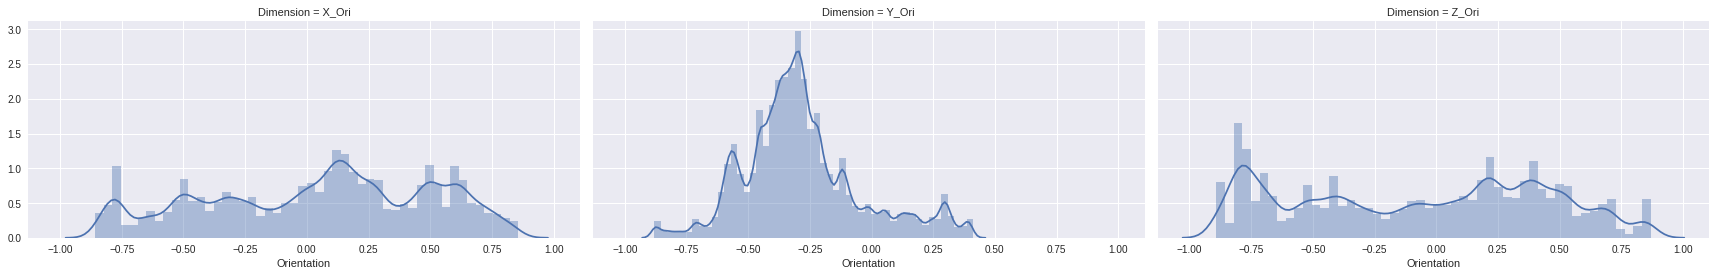

In [13]:
g = sns.FacetGrid(col='Dimension', data=pos_lSM, size=4, aspect=2)
g.map(sns.distplot, 'Position');

g = sns.FacetGrid(col='Dimension', data=ori_lSM, size=4, aspect=2)
g.map(sns.distplot, 'Orientation');


In [27]:
windowsize = 1000
DT = {}
df = pd.DataFrame()

for i in range(0,7):
    DT[i] = dfrat.copy().groupby(['session_id']).get_group(i)
    DT[i]['X_Pos'] = DT[i]['X_Pos'].rolling(window=windowsize).mean()
    DT[i]['Y_Pos'] = DT[i]['Y_Pos'].rolling(window=windowsize).mean()
    DT[i]['Z_Pos'] = DT[i]['Z_Pos'].rolling(window=windowsize).mean()

    DT[i]['X_Ori'] = DT[i]['X_Ori'].rolling(window=windowsize).mean()
    DT[i]['Y_Ori'] = DT[i]['Y_Ori'].rolling(window=windowsize).mean()
    DT[i]['Z_Ori'] = DT[i]['Z_Ori'].rolling(window=windowsize).mean()

    df = pd.concat([df, DT[i]], axis=0, ignore_index=True)


In [15]:
pos_l = dfrat.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Position', value_vars=['X_Pos', 'Y_Pos', 'Z_Pos'], var_name='Dimension')

ori_l = dfrat.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')


In [25]:
pos_lSM = df.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Position', value_vars=['X_Pos', 'Y_Pos', 'Z_Pos'], var_name='Dimension')

ori_lSM = df.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')


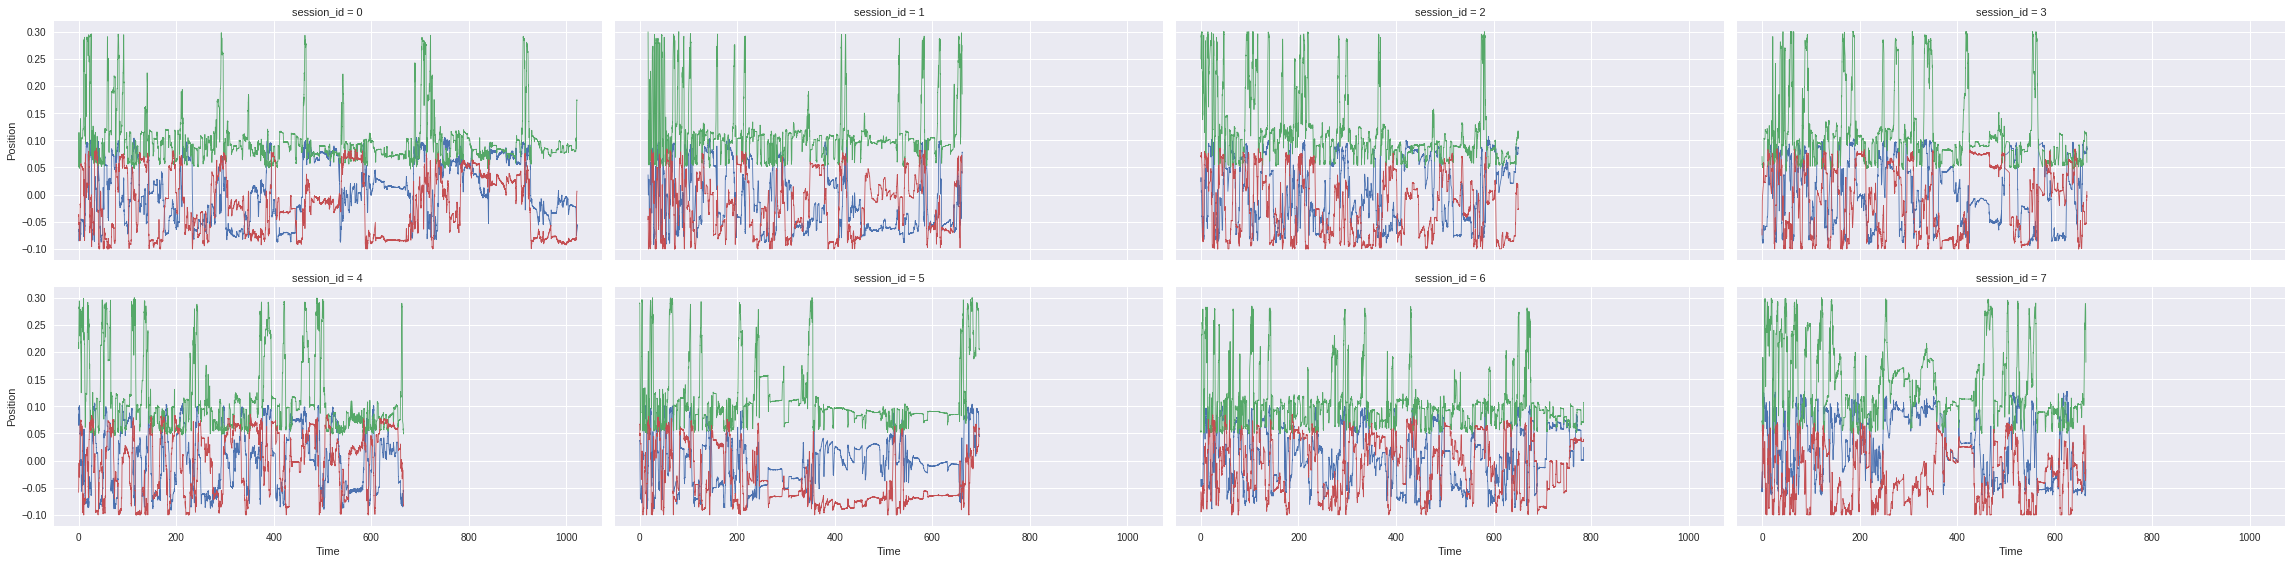

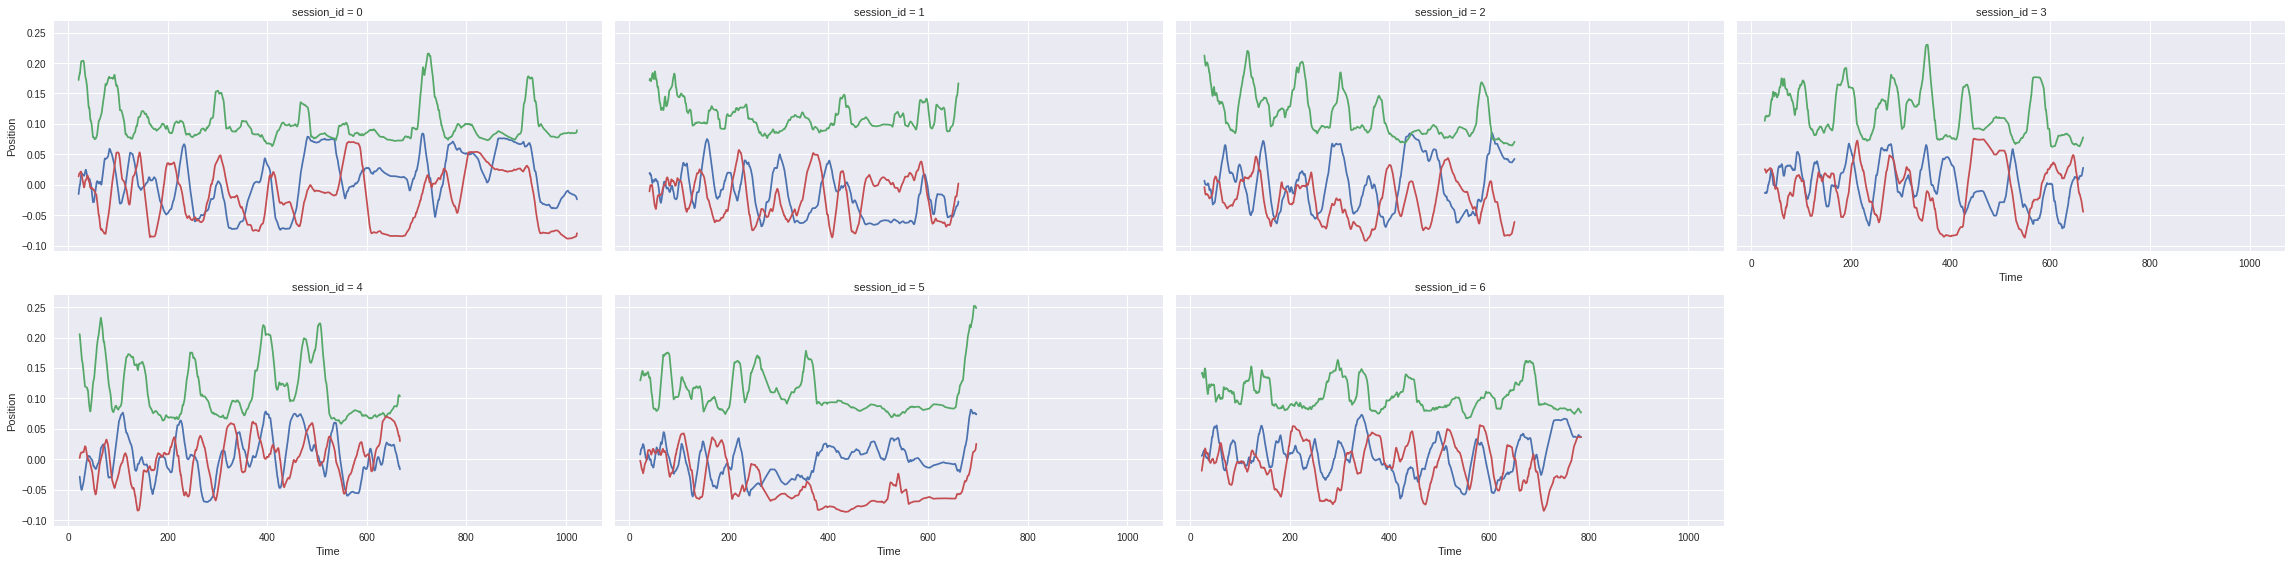

In [29]:
g = sns.FacetGrid(col='session_id', hue='Dimension', data=pos_l, size=4, aspect=2, col_wrap=4)
g.map(plt.plot, "Time", "Position", alpha=1, linewidth=0.8);

g = sns.FacetGrid(col='session_id', hue='Dimension', data=pos_lSM, size=4, aspect=2, col_wrap=4)
g.map(plt.plot, "Time", "Position", alpha=1);


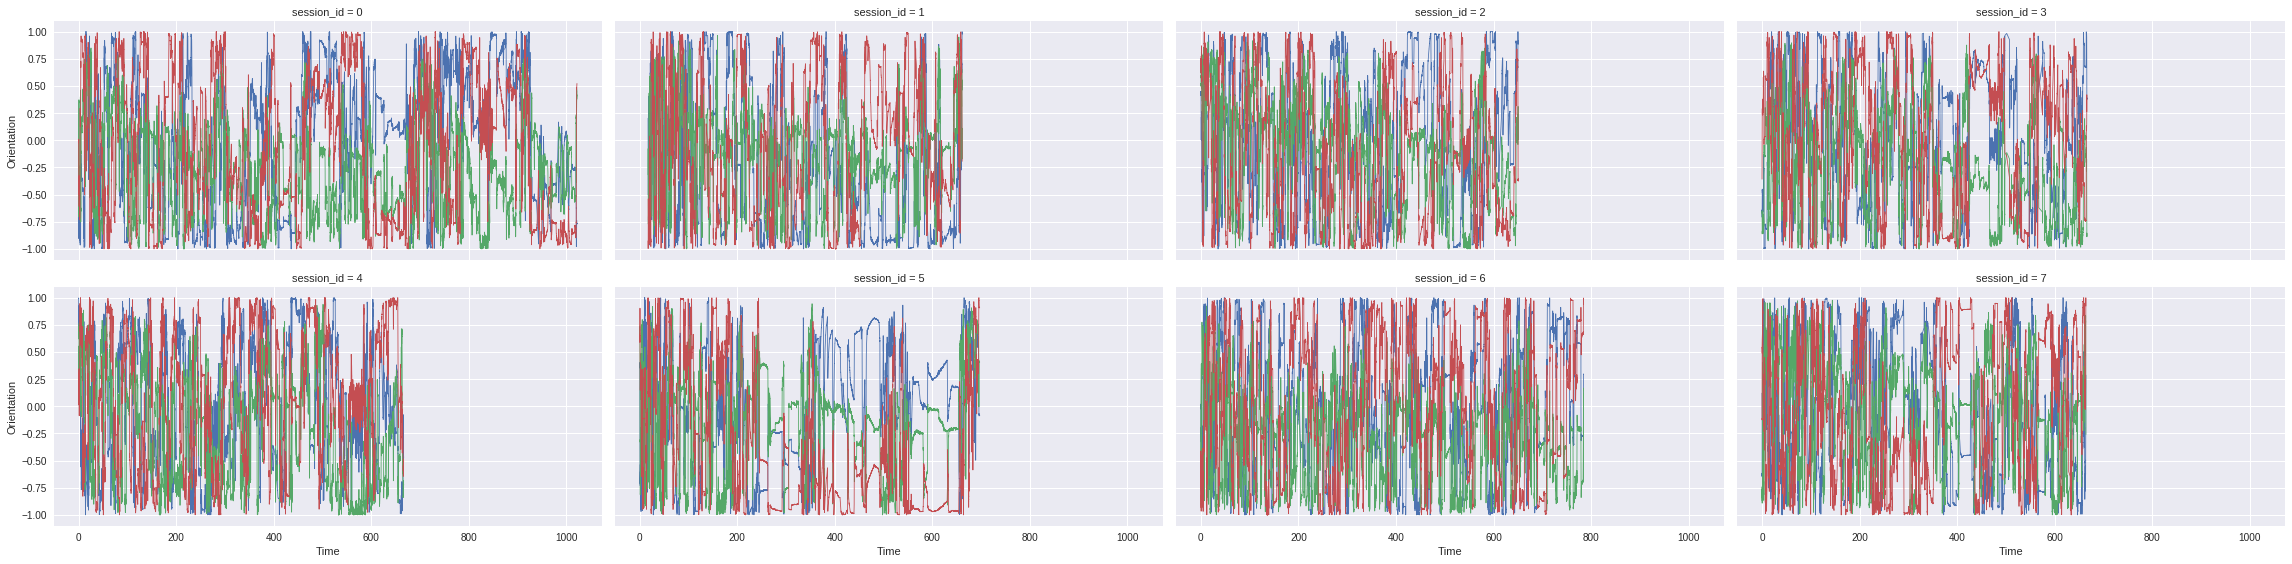

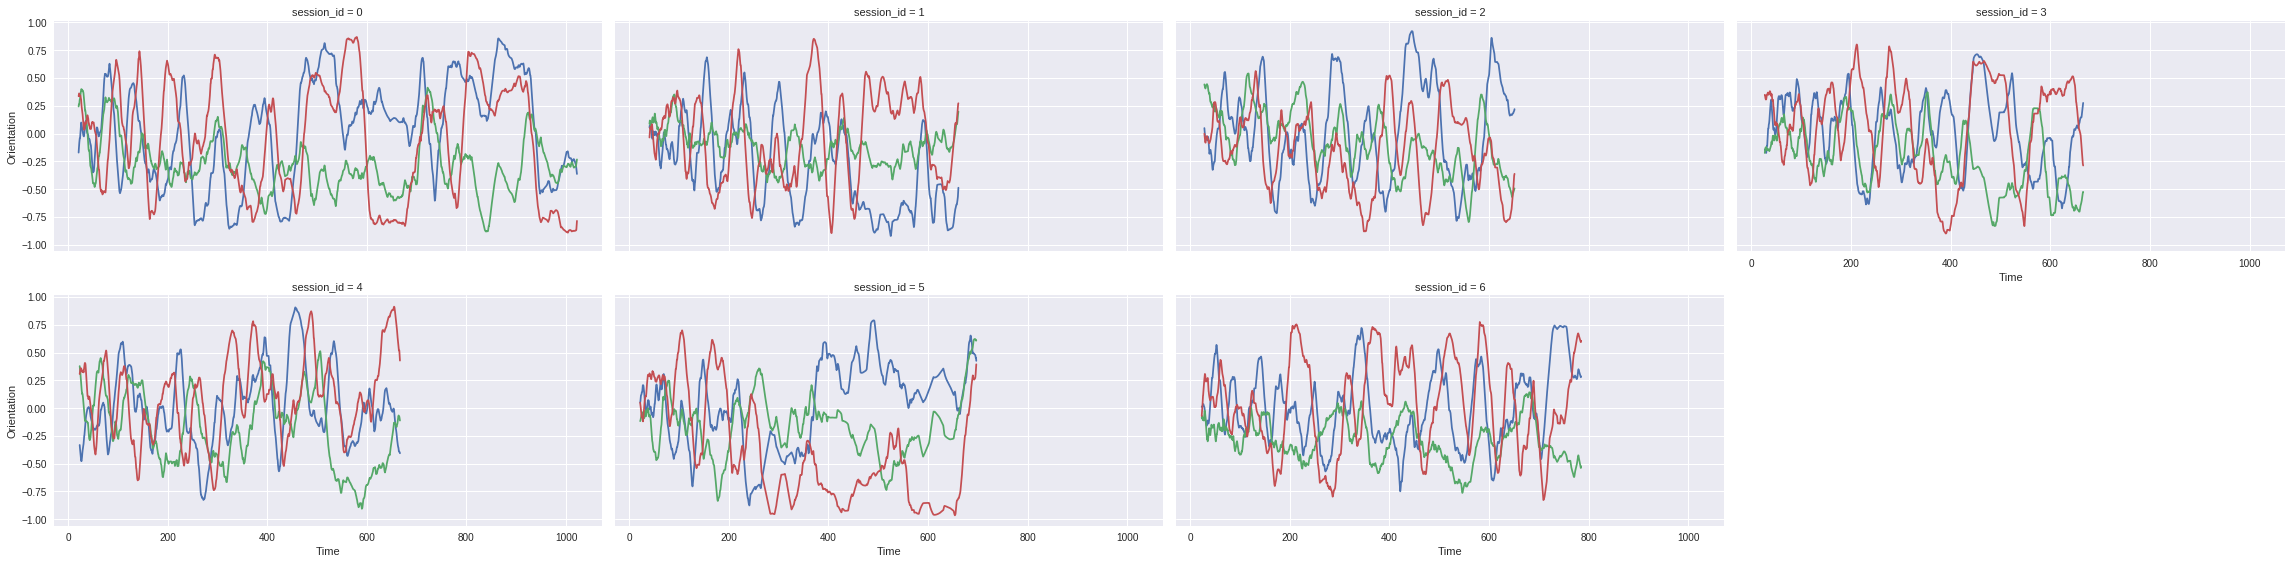

In [28]:
g = sns.FacetGrid(col='session_id', hue='Dimension', data=ori_l, size=4, aspect=2, col_wrap=4)
g.map(plt.plot, "Time", "Orientation", alpha=1, linewidth=0.8);

g = sns.FacetGrid(col='session_id', hue='Dimension', data=ori_lSM, size=4, aspect=2, col_wrap=4)
g.map(plt.plot, "Time", "Orientation", alpha=1);


## Distribution

In [ ]:
g = sns.FacetGrid(hue='session_id', col='Dimension', data=pos_l, size=4, aspect=2)
g.map(sns.distplot, 'Position');

g = sns.FacetGrid(hue='session_id', col='Dimension', data=ori_l, size=4, aspect=2)
g.map(sns.distplot, 'Orientation');


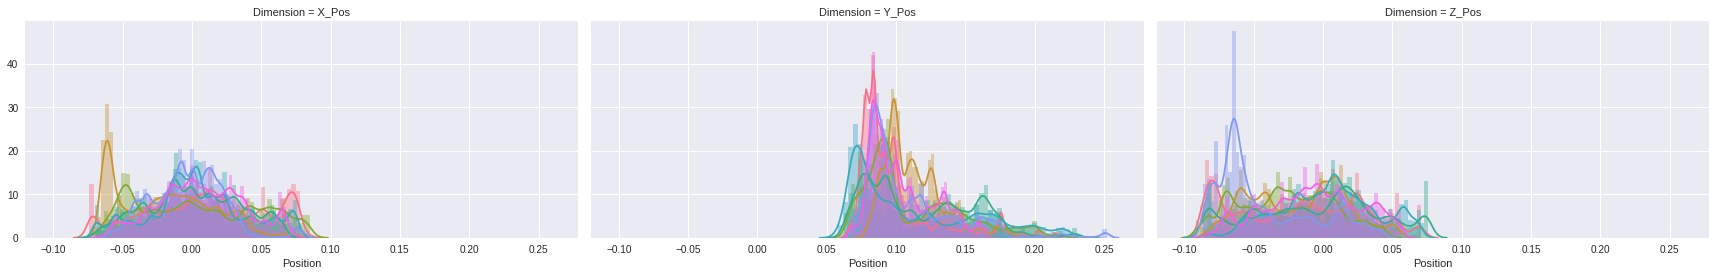

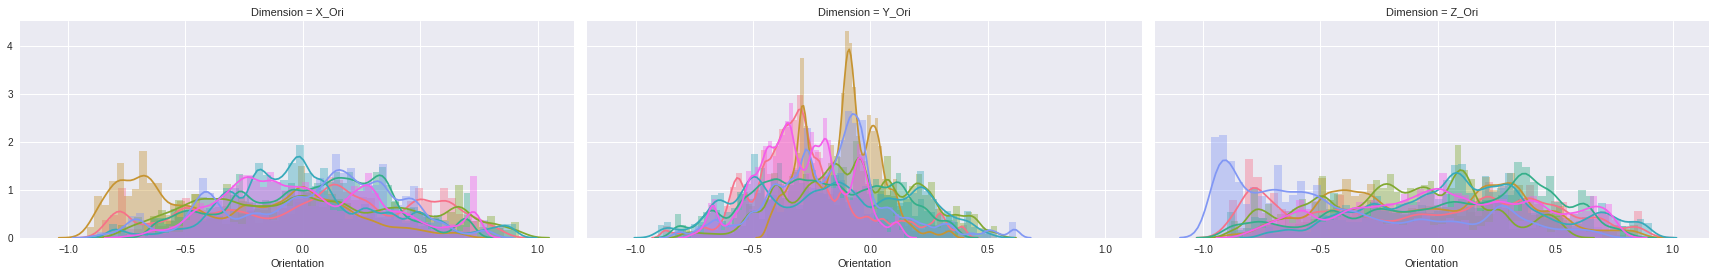

In [33]:
g = sns.FacetGrid(hue='session_id', col='Dimension', data=pos_lSM, size=4, aspect=2)
g.map(sns.distplot, 'Position');

g = sns.FacetGrid(hue='session_id', col='Dimension', data=ori_lSM, size=4, aspect=2)
g.map(sns.distplot, 'Orientation');


## Velocity - rapid movement removal
Removal based on speed of changes in the position of the animal - low pass filter of diagonal velocity.

In [30]:
#extraction of speed of positon changes and calculating velocity in all axes
df1 = df.copy()
df1['dT'] = df1['Time'].diff(-1)
df1 = df1[np.absolute(df1['dT']) < 1]


In [31]:
df1['dX_Pos'] = df1['X_Pos'].diff(-1)
df1['dY_Pos'] = df1['Y_Pos'].diff(-1)
df1['dZ_Pos'] = df1['Z_Pos'].diff(-1)

df1['dX_Pos'] = df1['X_Pos'] / df1['Time']
df1['dY_Pos'] = df1['Y_Pos'] / df1['Time']
df1['dZ_Pos'] = df1['Z_Pos'] / df1['Time']

df1['Vxyz'] = np.linalg.norm(df1[['dX_Pos','dY_Pos','dZ_Pos']].values,axis=1) # diagonal velocity

df1 = df1.replace([np.inf, -np.inf], np.nan).dropna()
#dfratnew4.max()


In [ ]:
g = sns.FacetGrid(col='session_id', data=df1, size=4, aspect=2, col_wrap=4)
g.map(plt.plot, "Time", "X", alpha=1, linewidth=0.8);

g = sns.FacetGrid(col='session_id', hue='Dimension', data=pos_lSM, size=4, aspect=2, col_wrap=4)
g.map(plt.plot, "Time", "Position", alpha=1);
